  <html> <body>  <center><h1> Predicting Score for NHL Games<h1/> <center/> <body/> <html/>

# Description
 The Goal of this project is to provide a ranking for variables that helps predicting scores for NHL games based on historic data. 
## Input : 
 - The data contains 2460 records of last year NHL games. There are total 30 teams and each team has played 82 games. There are wide variety of independent variables available like participating teams, Goalies, past performances of individual teams etc.
 
## Output :
 - Ranking of independent variables based on there power of predicting total no. of goals.

# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from pprint import pprint
from pandas.api.types import is_string_dtype,is_numeric_dtype
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV,ElasticNet,ElasticNetCV, RandomizedLasso,LinearRegression,Lasso,LassoCV,RidgeClassifier,RandomizedLogisticRegression,LogisticRegression,RidgeCV,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import r2_score,mean_squared_error,roc_auc_score,f1_score
%matplotlib inline

# Importing the data from excel file
## Data wrangling and cleaning
- Dropping unneccesary variables like *GAMEID, Game#, Game Time, Game month* etc. These variables have no connection with
 the game scores.
- Although *Team Golie ID, Opp Goalie ID* provide valuable information, but that information is already present in other variables, so I am dropping them as well.
- *Team* and *Opponent* variables contains useful information, but they are catergorical variables. Most of the regression algorithms deal with numeric variables. We create dummy variables for these two variables. For each team, we create a variable named *team_teamname* and *opp_teamname*. A *team_teamname* or *opp_teamname* variable contain 1 if that team is playing the game otherwise it contains 0. More details about the dummy variables (one hot encoding) can be found [here](https://www.moresteam.com/whitepapers/download/dummy-variables.pdf).

In [2]:
# importing the excel file
nhl = pd.read_excel("NHL.xlsx",skipinitialspace=True,index_col="Primary Key")
# drop columns containing all Nans if there are any.
nhl.dropna(axis=1,how='all',inplace=True)
# Create another dependent variable binary_goal which contains 1 if it is a high scoring game and 0 otherwise
nhl['binary_goals']=[0 if i<=6 else 1 for i in nhl["Total Regulation Goals"]]
# Dropping irrelavent variables
nhl.drop(["Team Goalie ID","Opp Goalie ID","GAMEID","Game#","Game Date","Game Time","Game Month","Opp Game#"],axis=1,inplace=True)
# Getting dummy variables for Team and Opponent variables.
nhl=pd.get_dummies(nhl,columns=["Team","Opponent"],prefix=["team_","opp_"])
nhl.head()

,Away?,Total Regulation Goals,Days Btwn Games,2 in 2?,Days Btwn 3 Games,3 in 4?,Days Btwn 4 Games,4 in 6?,Opp Days Btwn Games,Opp 2 in 2?,...,opp__Ottawa Senators,opp__Philadelphia Flyers,opp__Pittsburgh Penguins,opp__San Jose Sharks,opp__St. Louis Blues,opp__Tampa Bay Lightning,opp__Toronto Maple Leafs,opp__Vancouver Canucks,opp__Washington Capitals,opp__Winnipeg Jets
Primary Key,,,,,,,,,,,,,,,,,,,,,
Anaheim Ducks-01,@,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
Anaheim Ducks-02,@,5,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,0,0,1,0,0,0,0,0,0,0
Anaheim Ducks-03,@,4,1.0,Y,3.0,Y,NaN,NaN,1.0,Y,...,0,0,0,0,0,0,0,0,0,0
Anaheim Ducks-04,@,3,2.0,NaN,3.0,Y,5.0,Y,3.0,NaN,...,0,0,0,0,0,0,0,0,0,0
Anaheim Ducks-05,@,5,2.0,NaN,4.0,NaN,5.0,Y,2.0,NaN,...,0,1,0,0,0,0,0,0,0,0


In [3]:
print ("Total size of dataset:{}".format(nhl.shape))

Total size of dataset:(2460, 301)


# Imputing (filling) missing values in data
- There are some missing values in data. In order to fill missing values in binary variables (mostly ending with ?), we replace NaN's with 0.
- In order to deal with missing values in some of the continous variables, we first use interpolation to fill values that are in between two values. After that, we replace the initial values in many columns with the mean of that column.

In [4]:
# Repalcing NaN's with suitabe values
for i in nhl.columns.tolist():
    if nhl[i].isnull().values.any():
        if  i.endswith(("?","Rival","PGDR")):
            nhl[i].fillna(0,inplace=True)
        #else:
         #   nhl[i].fillna(nhl[i].mean(),inplace=True)
nhl = nhl.interpolate()
for i in nhl.columns:
    if nhl[i].isnull().values.any():
        nhl[i].fillna(nhl[i].mean(),inplace=True)
# Replacing Y and @ with 1
nhl.replace(["Y","@"],[1,1],inplace=True)
print ("Imputing missing values done")

Imputing missing values done


In [5]:
# Checking whether there are any more missing values left or not
if ~nhl.isnull().any().any():
    print ("Data is clean. No missing values")

Data is clean. No missing values


In [6]:
#writing clean data into file
W = pd.ExcelWriter("Clean_data.xlsx")
nhl.to_excel(W,'sheet1',header=nhl.columns.tolist(),index=False,startrow=1)
W.save()
print ("Writing Done")

Writing Done


## Getting to know more about variables:
 - How many of them are binary?
 - How many are numeric?

In [7]:
dependent = list()
Binary=list()
numeric = list()
for i in nhl.columns:
    if i in ["Total Regulation Goals","binary_goals"]:
        dependent.append(i)
    elif i.endswith(("?","Rival","PGDR")) or i.startswith(("team_","opp_")):
        Binary.append(i)
    else:
        numeric.append(i)
independent = [i for i in nhl.columns if i not in dependent]
print ("There are {} Dependent (target) variables:\n{}\n".format(len(dependent),dependent))
print ("There are {} Independent (predictor) variables as follows:\n".format(len(independent)))
print ("{} Binary variables:\n{}\n".format(len(Binary),Binary))
print ("{} Numeric variables:\n{}\n".format(len(numeric),numeric))

There are 2 Dependent (target) variables:
['Total Regulation Goals', 'binary_goals']

There are 299 Independent (predictor) variables as follows:

90 Binary variables:
['Away?', '2 in 2?', '3 in 4?', '4 in 6?', 'Opp 2 in 2?', 'Opp 3 in 4?', 'Opp 4 in 6?', 'Both 2 in 2?', 'Home only 2 in 2?', 'Opp only 2 in 2?', 'Neither 2 in 2?', 'Both 3 in 4?', 'Home only 3 in 4?', 'Opp only 3 in 4?', 'Neither 3 in 4?', 'Both 4 in 6?', 'Home only 4 in 6?', 'Opp only 4 in 6?', 'Neither 4 in 6?', 'Previous Game OT or SO?', 'Current Game Agnst Div Rival', 'Prev Game Agnst Div Rival', 'Opp PGDR', 'Both PGDR', 'Home PGDR', 'Neither PGDR', 'Team Backup For Any Minutes?', 'Team #1 Goalie Played?', 'Opp Backup For Any Minutes?', 'Opp #1 Goalie Played?', 'team__Anaheim Ducks', 'team__Arizona Coyotes', 'team__Boston Bruins', 'team__Buffalo Sabres', 'team__Calgary Flames', 'team__Carolina Hurricanes', 'team__Chicago Blackhawks', 'team__Colorado Avalanche', 'team__Columbus Blue Jackets', 'team__Dallas Stars', 'te

## Getting statistics about each variable like Mean,Standard Deviation etc.

In [8]:
description = nhl.describe(include=[np.number])
description = description.loc[:,numeric]
description.head()

,Days Btwn Games,Days Btwn 3 Games,Days Btwn 4 Games,Opp Days Btwn Games,Opp Days Btwn 3 Games,Opp Days Btwn 4 Games,Team-Opp Diff Days Btwn Games,Team-Opp Diff Days Btwn 3 Games,Team-Opp Diff Days Btwn 4 Games,Opp PGDR.1,...,Opp Goalie Rank.1,Opp Goalie Rank Group by 5,Team-Opp Diff Quality Start Percentile,Team-Opp Diff Quality Start% Percentile,Team-Opp Diff Save % Percentile,Team-Opp Diff GAA Percentile,Team-Opp Diff Weighted Avg 4 Goalie Stats,Team-Opp Diff Sum 4 Goalie Stats Percentile,Team-Opp Diff Goalie Rank,Team-Opp Diff Goalie Rank Group by 5
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.0,...,2460.000000,2460.000000,2.460000e+03,2.460000e+03,2.460000e+03,2.460000e+03,2.460000e+03,2.460000e+03,2460.000000,2460.000000
mean,2.187881,4.390155,6.580790,2.188695,4.387307,6.582044,0.005083,0.017080,0.048597,1.0,...,31.797967,6.832114,-9.838562e-18,-6.431170e-18,1.782675e-17,-3.204302e-18,-1.308800e-17,-4.513102e-20,0.000000,0.000000
std,0.973354,1.239215,1.421737,0.972767,1.238727,1.421410,1.232636,1.569868,1.806051,0.0,...,22.819198,4.589256,3.750623e-01,3.556663e-01,3.346788e-01,3.345251e-01,2.645711e-01,3.429765e-01,32.063714,6.451811
min,1.000000,2.000000,4.000000,1.000000,2.000000,4.000000,-7.000000,-8.000000,-9.000000,1.0,...,1.000000,1.000000,-1.000000e+00,-9.410000e-01,-9.260000e-01,-9.570000e-01,-8.442000e-01,-9.150000e-01,-86.000000,-17.000000
25%,2.000000,4.000000,6.000000,2.000000,4.000000,6.000000,0.000000,-1.000000,-1.000000,1.0,...,13.000000,3.000000,-2.230000e-01,-2.560000e-01,-2.450000e-01,-2.450000e-01,-1.701000e-01,-2.440000e-01,-23.000000,-5.000000


# Detecting Correlated Variables (Multicolinear variables)

- There are many variables in the data which are heavily correlated. This situation is called Multicolinearity. This can create problems in linear regression. There are many ways to detect these variables. Easiest way to do this to plot Correlation matrix.  

## Correlation Matrix Plot

- Each entry in the correlation matrix contains Pearson Correlation Coefficient value between the pair of variables.


- A correlation plot is a plot of correlation matrix where dark color represents strong correlation and light color represents a weak correlation.


- For the problem at hand, it is not possible to visualize the correlation plot for all the 209 variables,so we will plot it for certain group of variables.


- One can easily interpret plots to find out certain regions in the plot, where the entries are dark red. These are highly correlated set of variables.

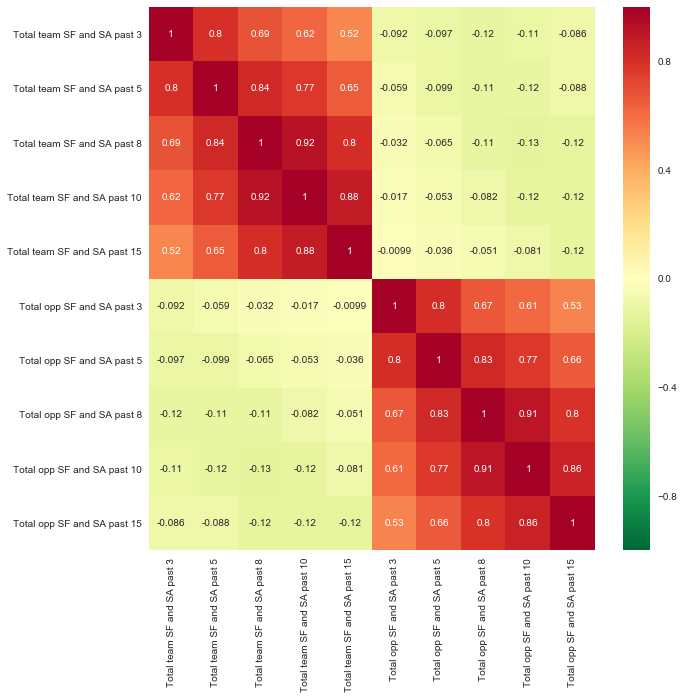

In [9]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
new_nhl = nhl.loc[:,[i for i in numeric if i.startswith(("Total team","Total opp"))]]
corr_opp = new_nhl.corr()
sns.heatmap(corr_opp,cmap='RdYlGn_r', vmin=-1,vmax=1, annot=True)

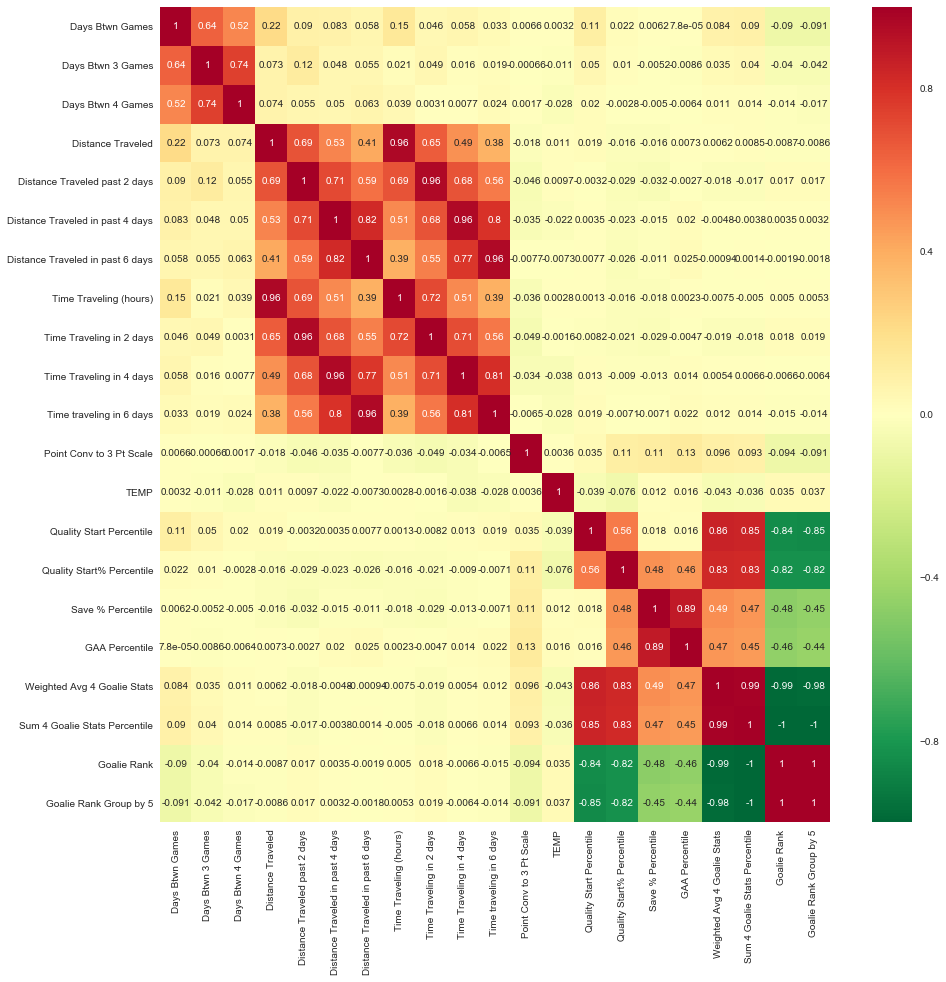

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
new_nhl = nhl.loc[:,[i for i in numeric if not i.startswith(("Team","Opp","Total"))]]
corr_opp = new_nhl.corr()
sns.heatmap(corr_opp,cmap='RdYlGn_r', vmin=-1,vmax=1, annot=True)

### Observations
- There are things a domain expert will always know, for example, there will be strong correlation between *Distance Traveled in past 2 days* and *Distance Traveled in past 4 days*, but correlation plot can reveal a lot of other interesting information as well. For example in plot above, there is a strong negative correlation between *Goalie Rank* and *Quality Start Percentile*. If rank of a goalie is low (large value), then his *Quality Start Percentile* will be low.


- One can also observe slight positive correlation 0.11 between *Days between games* and *Quality Start Percentile*.

## Pair Plot
- Pair plot can also be used for visualizing correlation between a set of variables.


- Pair plot is a stack of plots, where each stack is a scatter plot between two variables.


- If a plot is less scattered and less tilted towards either Y or X axis, it means a strong negative or postive correlation.


- In the following pair plot, it shows a strong positive correlation between *Time Travelling* and *Distance Traveled*.


- The Diagonal plots show the distribution of values using histogram.

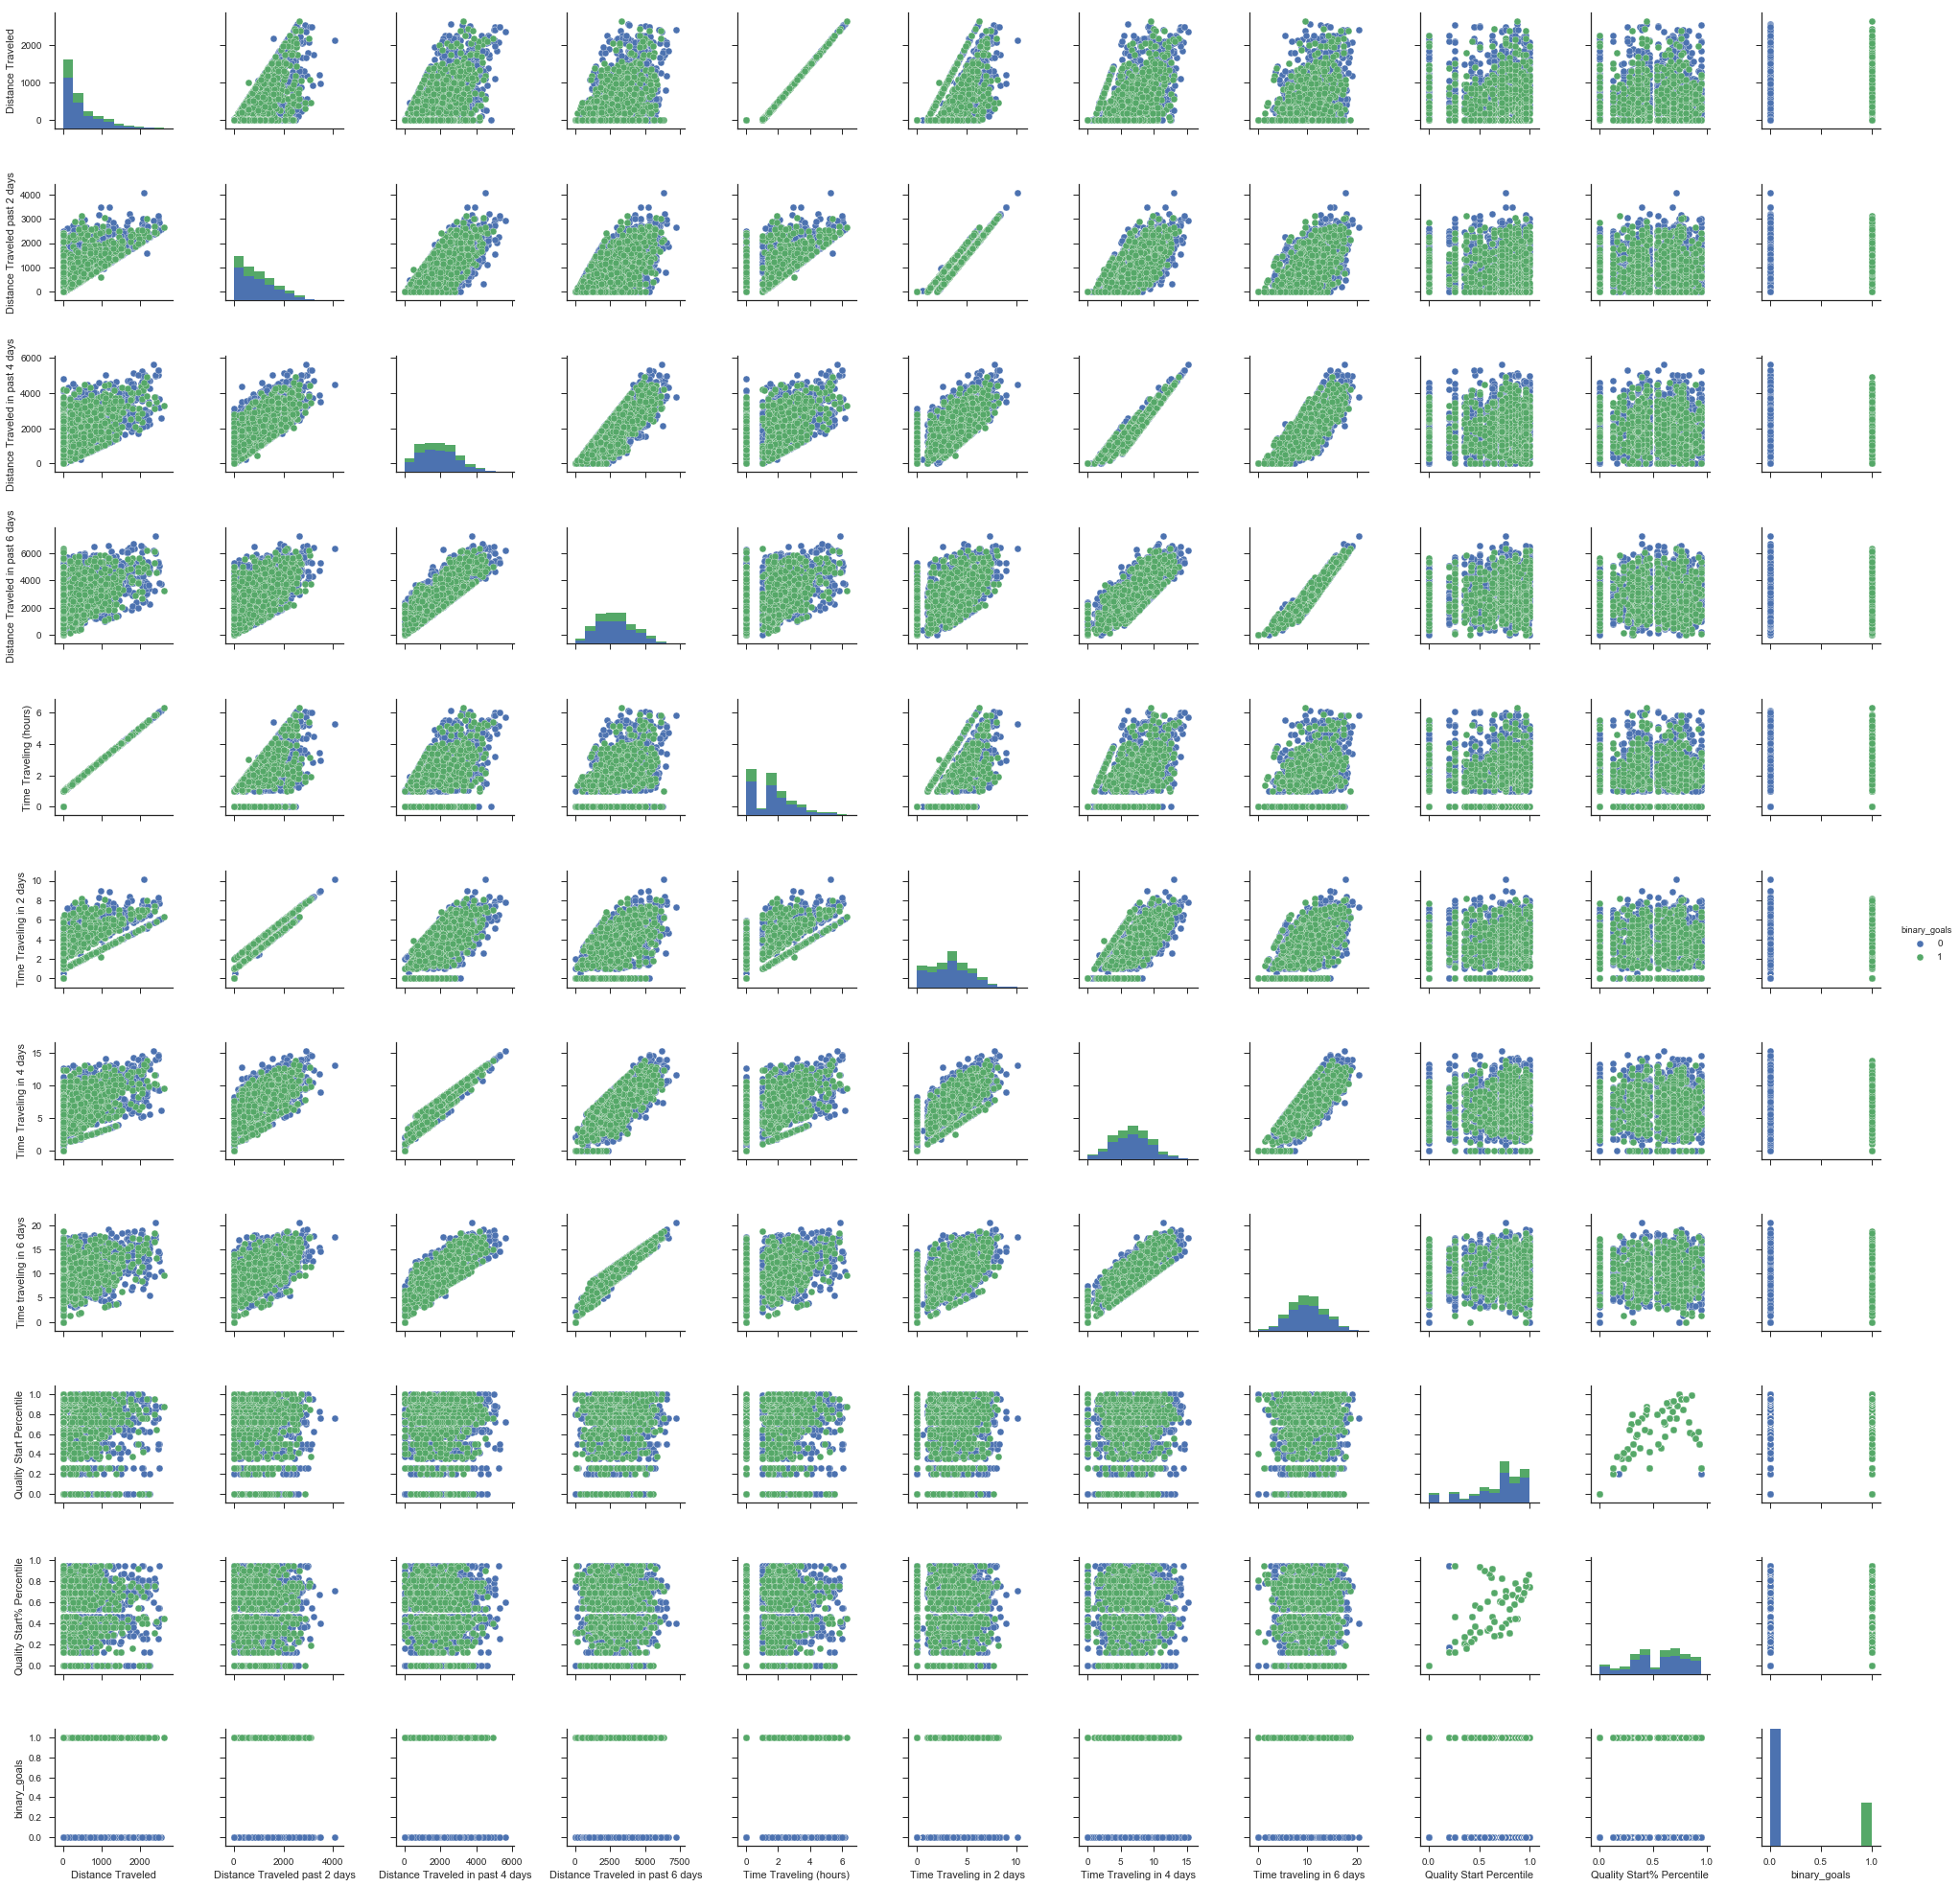

In [11]:
sns.set(style="ticks")
sns.pairplot(nhl.loc[:,[i for i in nhl.columns.tolist() if i.startswith(("Distance","Time","Quality","binary"))]], hue="binary_goals")

## Remedies for Multicolinearity
- In case of linear regression with very large number of variables, Multicolinearity can harm the modelling process. In linear regression, $(X^{T}X)^{-1}$ is calculated. Multicolinearity may results in a lot of non-orthogonal directions (variables).This can reduce the rank of the matrix $(X^{T}X)^{-1}$, which may result in ill-conditioned inverse.


- One way to solve this problem is to detect such highly correlated variables and dropping them (except one) from the variable set. This may not be the best idea, because these variables may have very high correlation with the dependent (response) variable. We may either want to retain all of them, or want to drop all of them (if they are not important).


- We use Regularization to deal with these problems. This will be discussed in the following section.


# Multiple Linear Regression


- Linear Regression assumes linear relationship between independent variable and dependent variable. It learns weights of different independent variables by minimizing **Least Square Objective** function.

   1. Linear regression works well when the number of features are small as compared to number of data samples. When the model becomes too complex (having comparable number of variables with data samples), it starts **overfitting**. A model is said to overfit when it *"overlearns"*. It performs very well on training data but performs poorly on out-of-sample (test/validation) data. To avoid this problem of overfitting, **Regularization** is used.   
  
   2. Regularization means smoothing out weights of variables so that they don't become very large. To do this, we add a regularization term (norm of the weight vector) in the least square objective function. This additional term control the sparsity of the data.
      - There are two types of norms which are used to control overfitting. One is called [Lasso Regularization](https://en.wikipedia.org/wiki/Lasso_(statistics) regularization and the other one is called [Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization).
      - Lasso introduces l1-norm (Manhattan distance) as a penalty term, whereas ridge regression introduces l2-norm (euclidean distance) as a penalty term. Lasso forces a lot coefficient to zeros and inherently perform model selection by feature selection. Ridge regression gives weights to every variable. It is much more interpretable than Lasso.
      ** Lasso is good for model selection (without multicolinearty) and Ridge regression is good from analytic point of view.**
      
      - [ElasticNet](https://en.wikipedia.org/wiki/Elastic_net_regularization) is a third kind of model, which combines both l1 
      and l2 penalties into the least square objective function.

# Methodology for Important Variable Selection
- We will adopt following methodology for getting feature ranking.

   - Divide dataset into training and validation dataset (70 %/30%)
   - Perform the three kind of linear regression Lasso, Ridge and ElasticNet
   - Lasso will automatically give sparse solution. Ridge will provide coefficients for every variable, which can 
   be used to interpret relationship between each independent variable and dependent variable.
   - Finally we will use **Stability Selection** method to rank variables according to their importance for prediction.

## Getting Training and Validation Sets

- *Disclaimer:* ** If you run following cell again, results in following cells may be slightly different for different train/validation split. It is random **

In [12]:
#teams = [i for i in independent if not i.startswith(("team_","opp_"))]
X = np.array(nhl.loc[:,independent])
y = np.array(nhl.loc[:,dependent[0]])
y1 = np.array(nhl.loc[:,dependent[1]])
r = np.random.permutation(nhl.shape[0])
train_id = r[:1700];val_id = r[1700:]
X_train = X[train_id,:];y_train = y[train_id];y_train1 = y1[train_id]
X_val = X[val_id,:];y_val = y[val_id];y_val1=y1[val_id]
print ("The size of training dataset is:{}".format(X_train.shape))
print ("The size of validation dataset is:{}".format(X_val.shape))

The size of training dataset is:(1700, 299)
The size of validation dataset is:(760, 299)


## Performing Lasso, Ridge and ElasticNet Regression
- We have used scikit-learn library for performing three type of regression.


- Paramters are automatically selected using cross-validation and experimentation.


- The coefficients obtained from each of the three models are stored in a dataframe for further analysis and comparison.

In [13]:
lasso = LassoCV(max_iter=10000).fit(X_train,y_train)
ridge = RidgeCV().fit(X_train,y_train)
elastic = ElasticNet(max_iter=10000).fit(X_train,y_train)
print ("The mean square error for Lasso: {}".format(mean_squared_error(y_val,lasso.predict(X_val))))
print ("The mean square error for Ridge: {}".format(mean_squared_error(y_val,ridge.predict(X_val))))
print ("The mean square error for ElasticNet: {}".format(mean_squared_error(y_val,elastic.predict(X_val))))
Coefficents = pd.DataFrame({"Lasso_coefficient":lasso.coef_,"Ridge_coefficient":ridge.coef_,"Elasticnet_coefficient":elastic.coef_},index=independent)
#print ("F1 score is : {}".format(mean_squared_error(y_val,p)))

The mean square error for Lasso: 5.61238947368421
The mean square error for Ridge: 5.226062421603454
The mean square error for ElasticNet: 5.658501750272391


## Analysis of Ridge Coefficients
- As expected, Lasso gives sparse solutions, whereas Ridge regression provides weights for every variable.

- These weights (coefficients) can be used to study relationship between independent and dependent variables.

For example,
*Given that all the other variable coefficents are unchanged* (look at the two tables in the following cells)-
 - if Los Angeles Kings is playing as an Opponent (**opp_Los Angeles Kings**), than it will decrease the number of goals by 0.7051 units.
 - if Los angeles Kings is playing as a Team (**team_Los Angeles Kings)**, it will decrease the number of goals by 0.8893 units.
 - if **Team Backup For Any Minutes?** increases by 1 unit, than it will increase the no. of goals by 1.8646 units.
 - if for a particular team, their **Goalie# 1 ** is playing, then it will increase the no. of goals by 1.7190 units.
 
Note that above interpretations are only true when all the other variable coefficients are unchanged.

In [14]:
# Getting 5 variables with minimum coefficients
Coefficents.sort_values("Ridge_coefficient").head(5)

,Elasticnet_coefficient,Lasso_coefficient,Ridge_coefficient
team__Los Angeles Kings,-0.0,-0.0,-0.889383
opp__Los Angeles Kings,-0.0,-0.0,-0.705150
Neither 4 in 6?,0.0,0.0,-0.501675
Neither 2 in 2?,0.0,0.0,-0.496394
opp__Boston Bruins,-0.0,-0.0,-0.489710


In [18]:
# Getting 5 variables with maximum coefficients
Coefficents.sort_values("Ridge_coefficient",ascending=False).head(5)

,Elasticnet_coefficient,Lasso_coefficient,Ridge_coefficient
Opp Backup For Any Minutes?,0.0,0.0,1.935934
Team Backup For Any Minutes?,0.0,0.0,1.864625
Opp #1 Goalie Played?,0.0,-0.0,1.733075
Team #1 Goalie Played?,0.0,0.0,1.719010
opp__Winnipeg Jets,0.0,0.0,0.474360


## Stability Selection (Randomized Lasso) Algorithm
As we have seen, l1 norm acts as a featuer selector algorithm. It simply gives zero weights to variables that it considers irrelavent. The problem is that it doesn't take into account multicolinearity present in the variable set.

To solve this problem Stability selection (a.k.a randomized lasso) was proposed. The idea behind randomized lasso is to perform l1 regularization for many iterations using randomly chosen data samples and randomly chosen features. After each iteration, for each variable, keep the record whether it was given weight greater than a particular user defined threshold or not. At the end, all the variables, which were selected in all the iterations will be given importance score 1.

More details of stability selection algorithm can be found [here](https://stat.ethz.ch/~nicolai/stability.pdf).

Stability selection is purely a feature selection algorithm. It returns importance scores of variables. 

To Performa Randomized Lasso, we use [RandomizedLasso](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.linear_model.RandomizedLasso.html) function in scikit-learn.
All the parameters are set after experimentation.

C:\Users\saurabh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


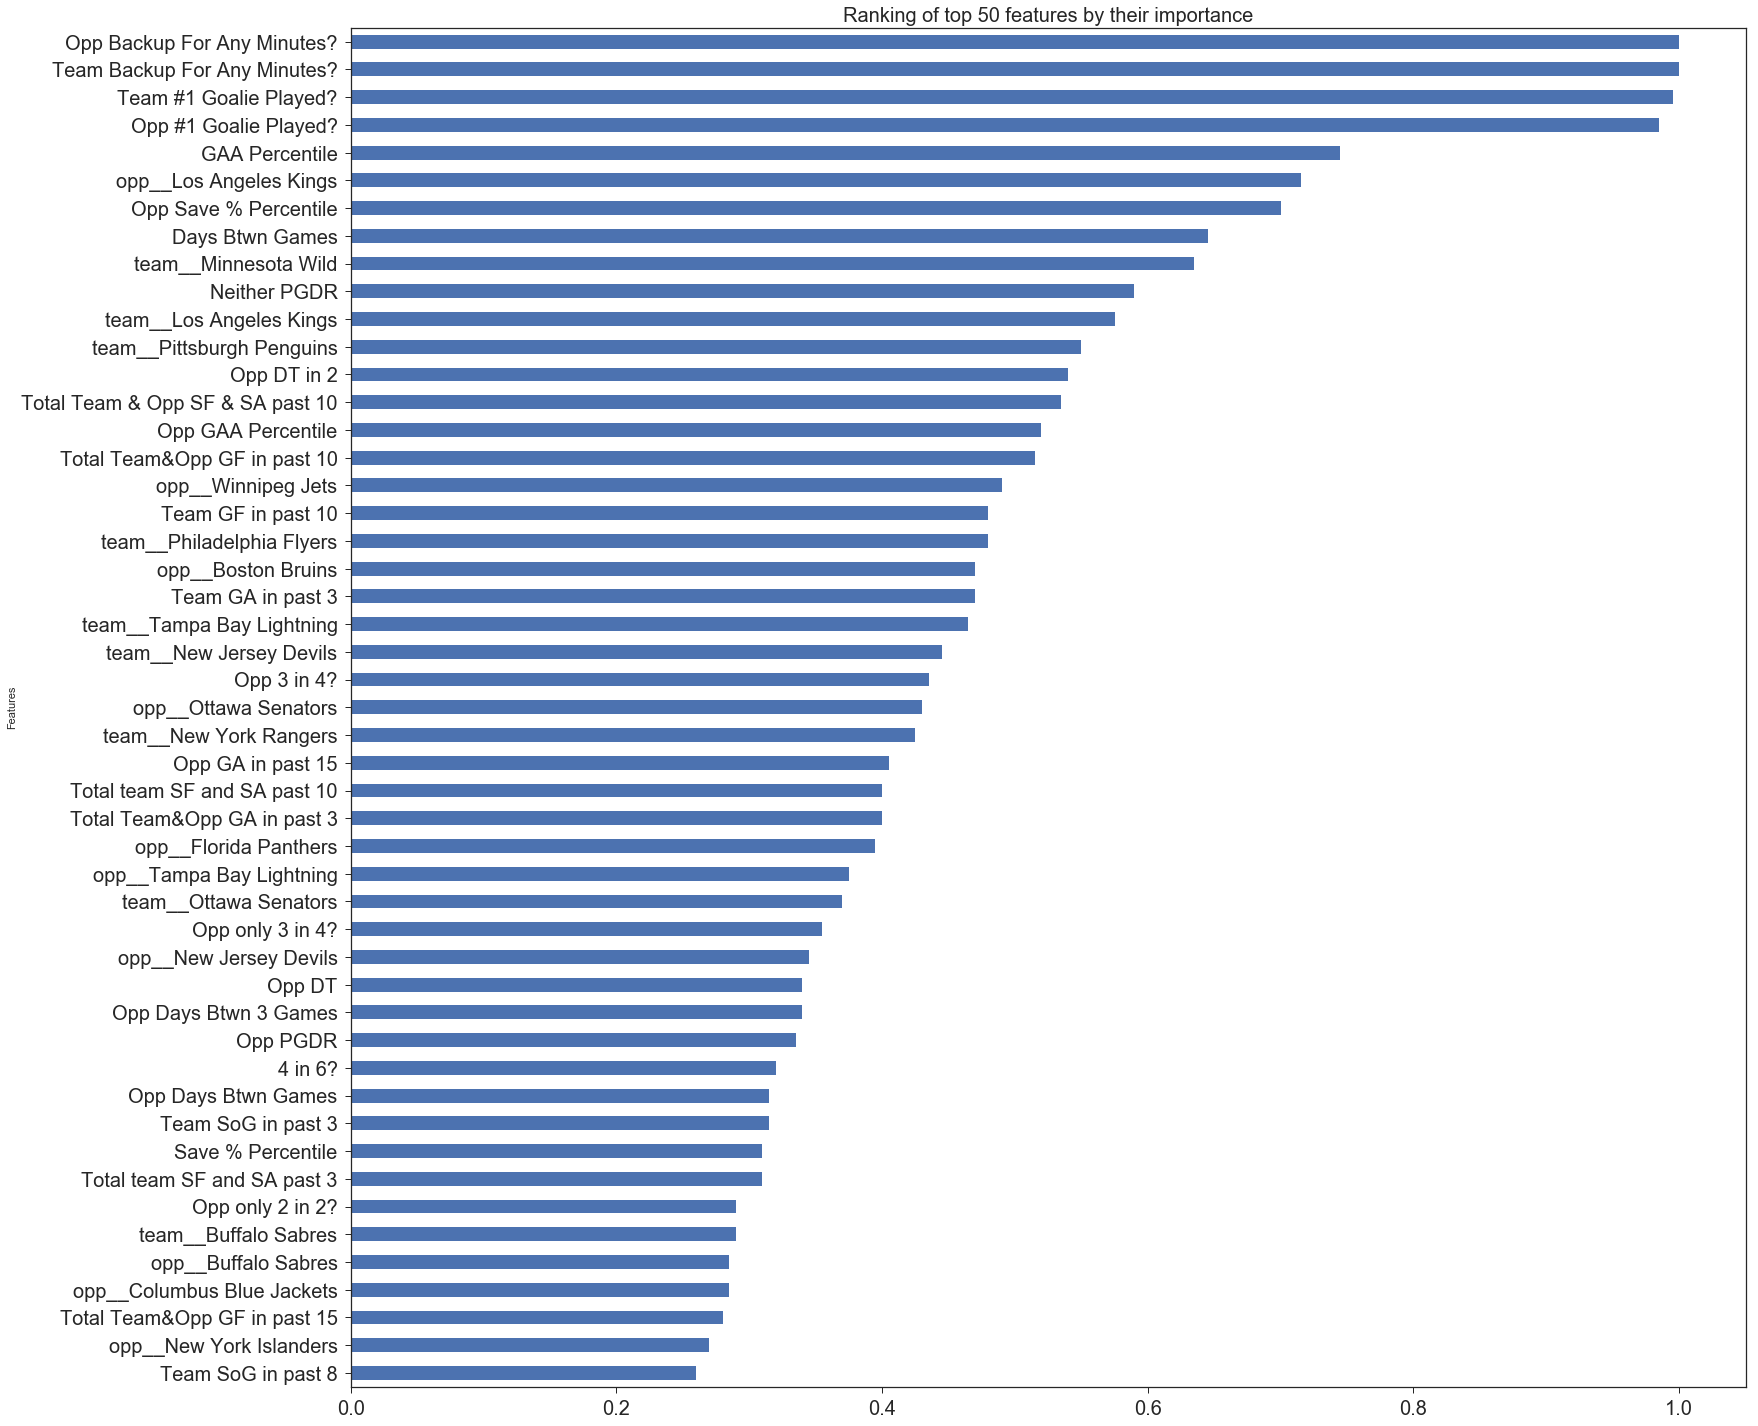

In [16]:
ln = RandomizedLasso(max_iter=50,selection_threshold=0.65).fit(X_train,y_train)
fig, axes = plt.subplots(figsize=(25,25))
axes.set_title("Ranking of top 50 features by their importance",fontsize=20)
#axes.legend(title="Importance_Score",fontsize=20)
scores_random = pd.DataFrame({"Features":independent,"Importance_Scores":ln.scores_})
scores_random = scores_random.sort_values("Importance_Scores",ascending=True)
scores_random[250:].plot.barh(x="Features",y="Importance_Scores",ax=axes,fontsize=20,mark_right=False,legend=False)
#axes.legend(loc=(0.7,0.7),title="Importance_Score",fontsize=20)

## Validating the performance using selected features

Since we have selected 0.65 thershold during calculating scores in RandomizedLasso, we will select all those variables whose 
score is greater than 0.65. We will perform linear regression using these variables to see whether they outperform other three methods or not.

In [20]:
my_feat = scores_random[scores_random["Importance_Scores"]>0.65].index.values
linreg = LinearRegression().fit(X_train[:,my_feat],y_train)
print ("The mean square error for Randomized Lasso is {}".format(mean_squared_error(y_val,linreg.predict(X_val[:,my_feat]))))

The mean square error for Randomized Lasso is 4.950531653610611


RandomizedLasso outperformed all the three methods: Lasso, Ridge and ElasticNet. The final ranking of features is given above in the graph.

# Final Remarks and Conclusion
- Most important four variables for predicting the no of goals are:
 - **Team Backup For Any Minutes?**
 - **Opp Backup For Any Minutes?**
 - **Team #1 Goalie Played?**
 - **Opp #1 Goalie Played?**
- Apart from above mentioned variables, participating teams also makes a huge difference in match scores. 
- **Days between games** also have some impact on goal scoring. Perhaps the players get more time to relax.